In [150]:
import sklearn
from sklearn.manifold import Isomap
from sklearn import datasets
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.cluster import KMeans
from sklearn import preprocessing
from sklearn.cluster import MeanShift
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

import pandas as pd
import numpy as np
import scipy.stats
import pylab as plt
from matplotlib import pyplot as plt
from scipy import stats
import random
import math

In [29]:
import urllib.request
urllib.request.urlretrieve("https://raw.githubusercontent.com/nshaud/ml_for_astro/main/stars.csv", "stars.csv")

('stars.csv', <http.client.HTTPMessage at 0x26c2423f4d0>)

In [30]:
df_stars = pd.read_csv("stars.csv")
df_stars

Temperature (K)  Luminosity(L/Lo)  Radius(R/Ro)  Absolute magnitude(Mv)  \
0               3068          0.002400        0.1700                   16.12   
1               3042          0.000500        0.1542                   16.60   
2               2600          0.000300        0.1020                   18.70   
3               2800          0.000200        0.1600                   16.65   
4               1939          0.000138        0.1030                   20.06   
..               ...               ...           ...                     ...   
235            38940     374830.000000     1356.0000                   -9.93   
236            30839     834042.000000     1194.0000                  -10.63   
237             8829     537493.000000     1423.0000                  -10.73   
238             9235     404940.000000     1112.0000                  -11.23   
239            37882     294903.000000     1783.0000                   -7.80   

       Star type Star color Spectral Class  
0    Brown Dwarf        Red              M  
1    Brown Dwarf        Red              M  
2    Brown Dwarf        Red              M  
3    Brown Dwarf        Red              M  
4    Brown Dwarf        Red              M  
..           ...        ...            ...  
235   Hypergiant       Blue              O  
236   Hypergiant       Blue              O  
237   Hypergiant      White              A  
238   Hypergiant      White              A  
239   Hypergiant       Blue              O  

[240 rows x 7 columns]

There are 6 star types that are encoded in the 'Star type' column. These labels are currently encoded as strings which is practical for reading but not for computing. Using scikit-learn, we will convert this column into integers by assigning a unique int value to each star type.

In [31]:
le = LabelEncoder()
# Assign unique integers from 0 to 6 to each star type
df_stars['Star type'] = le.fit_transform(df_stars['Star type'])
labels = le.inverse_transform(df_stars['Star type'])
class_names = le.classes_
print(class_names)

['Brown Dwarf' 'Hypergiant' 'Main Sequence' 'Red Dwarf' 'Supergiant'
 'White Dwarf']


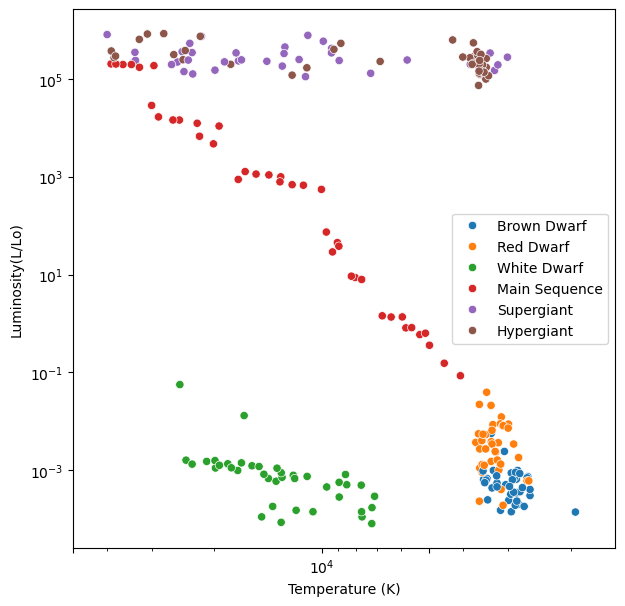

In [5]:
import seaborn as sns

fig = plt.figure(figsize=(7, 7))
sns.scatterplot(data=df_stars, x='Temperature (K)', y='Luminosity(L/Lo)', hue=labels)

plt.xscale('log')
plt.yscale('log')
plt.xticks([5000, 10000, 50000])
plt.xlim(5e4, 1.5e3)
plt.show()

In [183]:
X = np.array(df_stars.drop(['Star type','Star color','Spectral Class'],axis=1))
X[:,0] = np.log10(X[:,0])
X[:,1] = np.log10(X[:,1])
X[:,2] = np.log10(X[:,2])
n_components = 4
pca = PCA(n_components=n_components)
pca.fit(X)

eigenvalues = pca.transform(X) # compute the subspace projection of X
mean = pca.mean_ 
eigenvectors = pca.components_ 

print(eigenvalues.shape)
print(eigenvectors.shape)

pca_data = pca.fit_transform(X)

(240, 4)
(4, 4)


Let's plot the first two principal components.

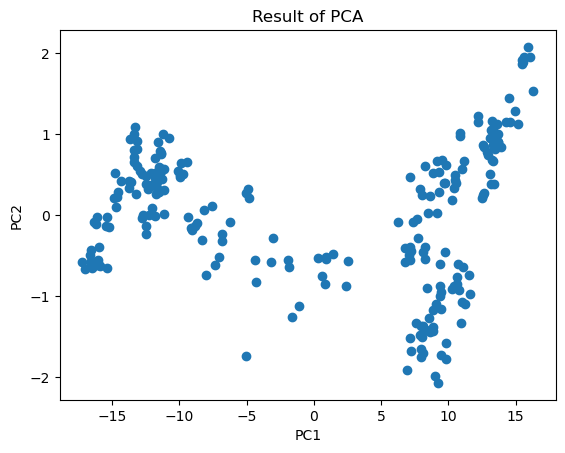

In [184]:
plt.scatter(pca_data[:,0],pca_data[:,1])
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('Result of PCA')
plt.show()

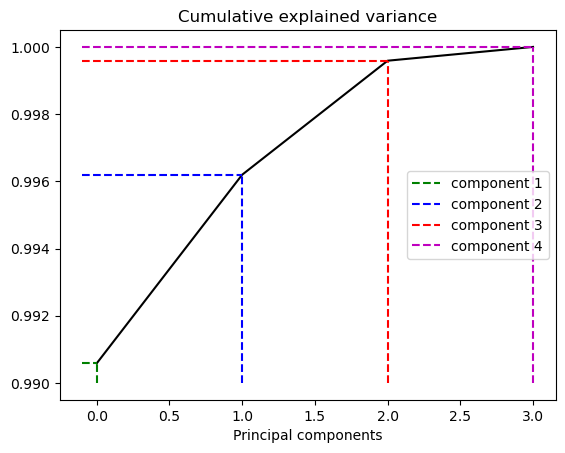

In [185]:
plt.plot(np.arange(n_components),pca.explained_variance_ratio_.cumsum(),'k')
plt.title('Cumulative explained variance')
#plt.xlim(-0.1,3.1)
#plt.ylim(0.99,1)

plt.plot(np.zeros(2),np.linspace(0.99,pca.explained_variance_ratio_.cumsum()[0],2),'--',c='g',label='component 1')
plt.plot(np.linspace(-0.1,0,2),np.ones(2)*pca.explained_variance_ratio_.cumsum()[0],'--',c='g')

plt.plot(np.ones(2),np.linspace(0.99,pca.explained_variance_ratio_.cumsum()[1],2),'--',c='b',label='component 2')
plt.plot(np.linspace(-0.1,1,2),np.ones(2)*pca.explained_variance_ratio_.cumsum()[1],'--',c='b')

plt.plot(np.ones(2)*2,np.linspace(0.99,pca.explained_variance_ratio_.cumsum()[2],2),'--',c='r',label='component 3')
plt.plot(np.linspace(-0.1,2,2),np.ones(2)*pca.explained_variance_ratio_.cumsum()[2],'--',c='r')

plt.plot(np.ones(2)*3,np.linspace(0.99,pca.explained_variance_ratio_.cumsum()[3],2),'--',c='m',label='component 4')
plt.plot(np.linspace(-0.1,3,2),np.ones(2)*pca.explained_variance_ratio_.cumsum()[3],'--',c='m')

plt.xlabel('Principal components')
plt.legend()
plt.show()

In [187]:
print('Explained covariance')
print('First component: ', np.round(pca.explained_variance_ratio_[0],3), ' %')
print('Second component: ', np.round(pca.explained_variance_ratio_[1],3), ' %')
print('Third component: ', np.round(pca.explained_variance_ratio_[2],3), ' %')
print('Fourth component: ', np.round(pca.explained_variance_ratio_[3],3), ' %')

Explained covariance
First component:  0.991  %
Second component:  0.006  %
Third component:  0.003  %
Fourth component:  0.0  %


Let's use K-Means to find clusters in our data.

C:\Users\giuli\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


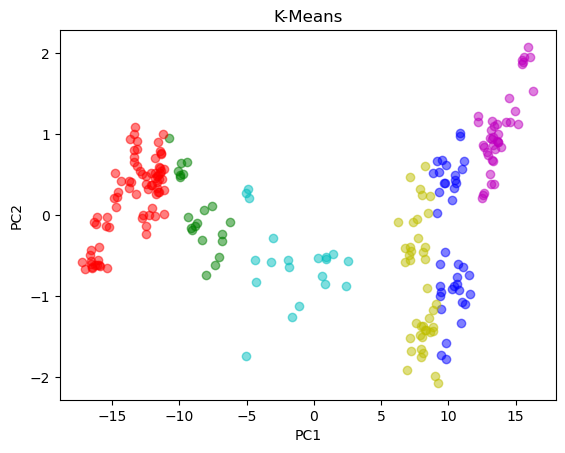

In [188]:
X = np.vstack((pca_data[:,0],pca_data[:,1])).T
n_clusters = 6
clf = KMeans(n_clusters=n_clusters,n_init='auto')
clf.fit(X)
centers = clf.cluster_centers_ #location of the clusters
labels = clf.predict(X) #labels for each of the points

# plot the data color-coded by cluster id
colors = ['g','b','r','c','m','y']
for ii in range(n_clusters):
    plt.scatter(X[labels==ii,0],X[labels==ii,1], 
                c=colors[ii],alpha=0.5)

plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('K-Means')
plt.show()

Let's see what happens if we standardize our data first.

In [189]:
#X = np.log10(np.array(df_stars.drop(['Radius(R/Ro)','Absolute magnitude(Mv)','Star type','Star color','Spectral Class'],axis=1)))
X = np.array(df_stars.drop(['Star type','Star color','Spectral Class'],axis=1))
X[:,0] = np.log10(X[:,0])
X[:,1] = np.log10(X[:,1])
X[:,2] = np.log10(X[:,2])

#standardize the data
scaler = StandardScaler()
data_scaled = scaler.fit_transform(X)

n_components = 4
pca = PCA(n_components=n_components)
pca.fit(data_scaled)

eigenvalues = pca.transform(data_scaled) # compute the subspace projection of X
mean = pca.mean_ 
eigenvectors = pca.components_ 

print(eigenvalues.shape)
print(eigenvectors.shape)

pca_data = pca.fit_transform(data_scaled)

(240, 4)
(4, 4)


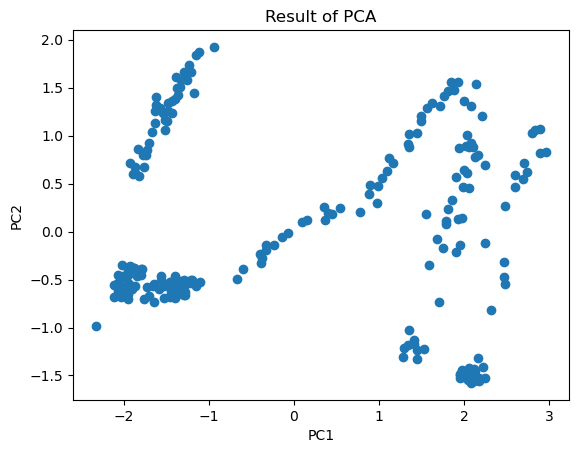

In [190]:
plt.scatter(pca_data[:,0],pca_data[:,1])
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('Result of PCA')
plt.show()

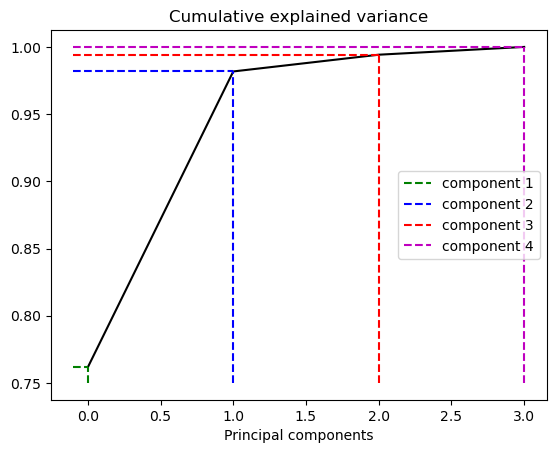

In [191]:
plt.plot(np.arange(n_components),pca.explained_variance_ratio_.cumsum(),'k')
plt.title('Cumulative explained variance')
#plt.xlim(-0.1,3.1)
#plt.ylim(0.99,1)

plt.plot(np.zeros(2),np.linspace(0.75,pca.explained_variance_ratio_.cumsum()[0],2),'--',c='g',label='component 1')
plt.plot(np.linspace(-0.1,0,2),np.ones(2)*pca.explained_variance_ratio_.cumsum()[0],'--',c='g')

plt.plot(np.ones(2),np.linspace(0.75,pca.explained_variance_ratio_.cumsum()[1],2),'--',c='b',label='component 2')
plt.plot(np.linspace(-0.1,1,2),np.ones(2)*pca.explained_variance_ratio_.cumsum()[1],'--',c='b')

plt.plot(np.ones(2)*2,np.linspace(0.75,pca.explained_variance_ratio_.cumsum()[2],2),'--',c='r',label='component 3')
plt.plot(np.linspace(-0.1,2,2),np.ones(2)*pca.explained_variance_ratio_.cumsum()[2],'--',c='r')

plt.plot(np.ones(2)*3,np.linspace(0.75,pca.explained_variance_ratio_.cumsum()[3],2),'--',c='m',label='component 4')
plt.plot(np.linspace(-0.1,3,2),np.ones(2)*pca.explained_variance_ratio_.cumsum()[3],'--',c='m')

plt.xlabel('Principal components')
plt.legend()
plt.show()

In [192]:
print('Explained covariance')
print('First component: ', np.round(pca.explained_variance_ratio_[0],2), ' %')
print('Second component: ', np.round(pca.explained_variance_ratio_[1],2), ' %')
print('Third component: ', np.round(pca.explained_variance_ratio_[2],2), ' %')
print('Fourth component: ', np.round(pca.explained_variance_ratio_[3],2), ' %')

Explained covariance
First component:  0.76  %
Second component:  0.22  %
Third component:  0.01  %
Fourth component:  0.01  %


C:\Users\giuli\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


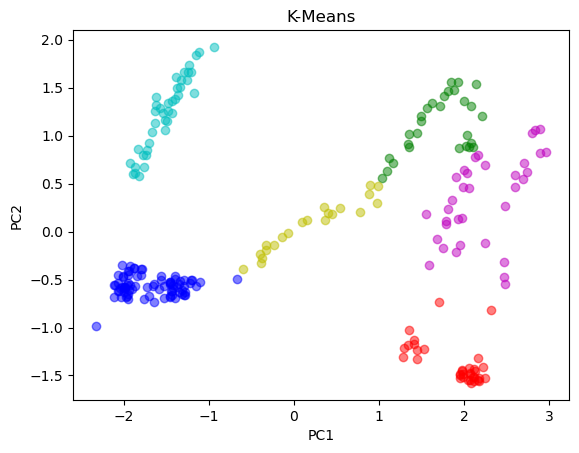

In [193]:
X = np.vstack((pca_data[:,0],pca_data[:,1])).T
n_clusters = 6
clf = KMeans(n_clusters=n_clusters,n_init='auto')
clf.fit(X)
centers = clf.cluster_centers_ #location of the clusters
labels = clf.predict(X) #labels for each of the points

# plot the data color-coded by cluster id
colors = ['g','b','r','c','m','y']
for ii in range(n_clusters):
    plt.scatter(X[labels==ii,0],X[labels==ii,1], 
                c=colors[ii],alpha=0.5)

plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('K-Means')
plt.show()

# No

In [6]:
X = np.array(df_stars.drop(['Star type', 'Star color', 'Spectral Class'],axis=1))
n_components = 3
pca = PCA(n_components=n_components)
pca.fit(X)

PCA(n_components=3)

In [7]:
eigenvalues = pca.transform(X) # compute the subspace projection of X
mean = pca.mean_ 
eigenvectors = pca.components_ 

print(eigenvalues.shape)
print(eigenvectors.shape)

(240, 3)
(3, 4)


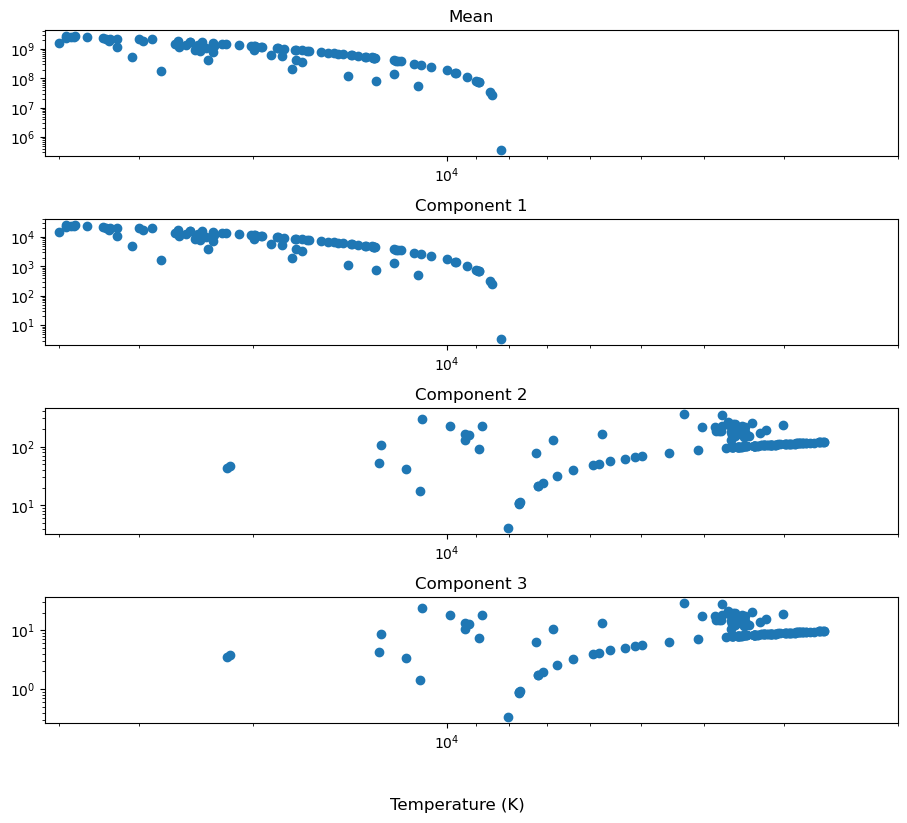

In [8]:
fig, axes = plt.subplots(n_components+1,1,figsize=(11,9))
fig.subplots_adjust(hspace=0.5)

for i in range(n_components+1):
    if i<1:
        axes[i].scatter(df_stars['Temperature (K)'],eigenvalues[:,1]*mean[1])
        axes[i].set_title('Mean')
    else:
        axes[i].scatter(df_stars['Temperature (K)'],eigenvalues[:,1]*eigenvectors[i-1,1])
        axes[i].set_title('Component '+str(i))

    axes[i].set_xscale('log')
    axes[i].set_yscale('log')
    axes[i].set_xlim(4.2e4,2e3)
fig.supxlabel('Temperature (K)')
plt.show()

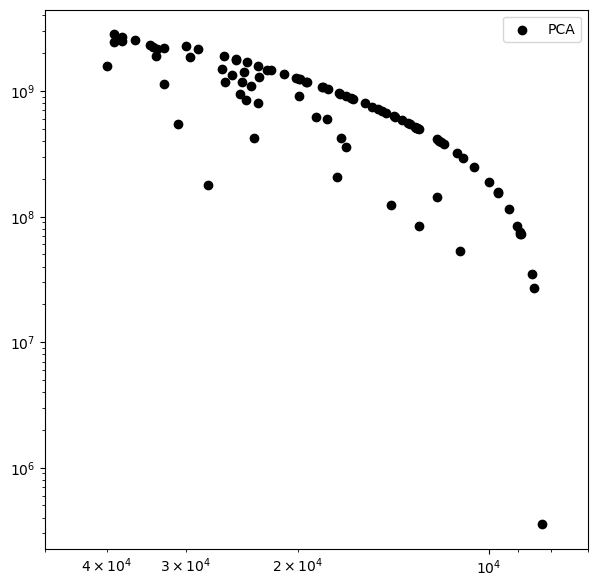

In [9]:
fig = plt.figure(figsize=(7, 7))
total = np.sum([eigenvalues[:,1]*eigenvectors[i,1] for i in range(n_components)])
total = total + eigenvalues[:,1]*mean[1]
plt.scatter(df_stars['Temperature (K)'],total,c='k',label='PCA')
#sns.scatterplot(data=df_stars, x='Temperature (K)', y='Luminosity(L/Lo)', hue=labels)
plt.xscale('log')
plt.yscale('log')
plt.xticks([10000])
plt.xlim(5e4, 7e3)
plt.legend()
plt.show()

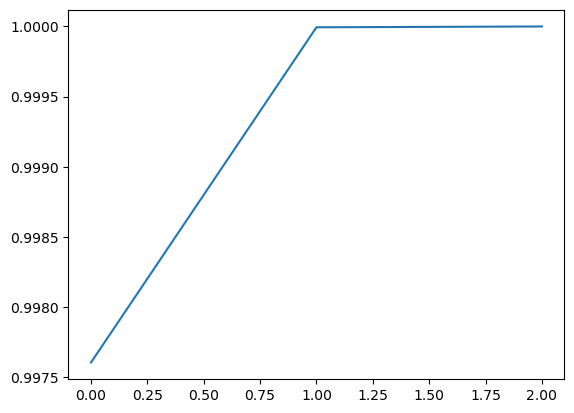

In [10]:
plt.plot(np.arange(n_components),pca.explained_variance_ratio_.cumsum())

In [11]:
X[:,0] = np.log10(X[:,0])
X[:,1] = np.log10(X[:,1])
X[:,2] = np.log10(X[:,2])
X = X-np.mean(X)
n_components = 3
pca = PCA(n_components=n_components,whiten=True)
pca.fit(X)

PCA(n_components=3, whiten=True)

In [12]:
eigenvalues = pca.transform(X) # compute the subspace projection of X
mean = pca.mean_ 
eigenvectors = pca.components_ 

print(eigenvalues.shape)
print(eigenvectors.shape)

(240, 3)
(3, 4)


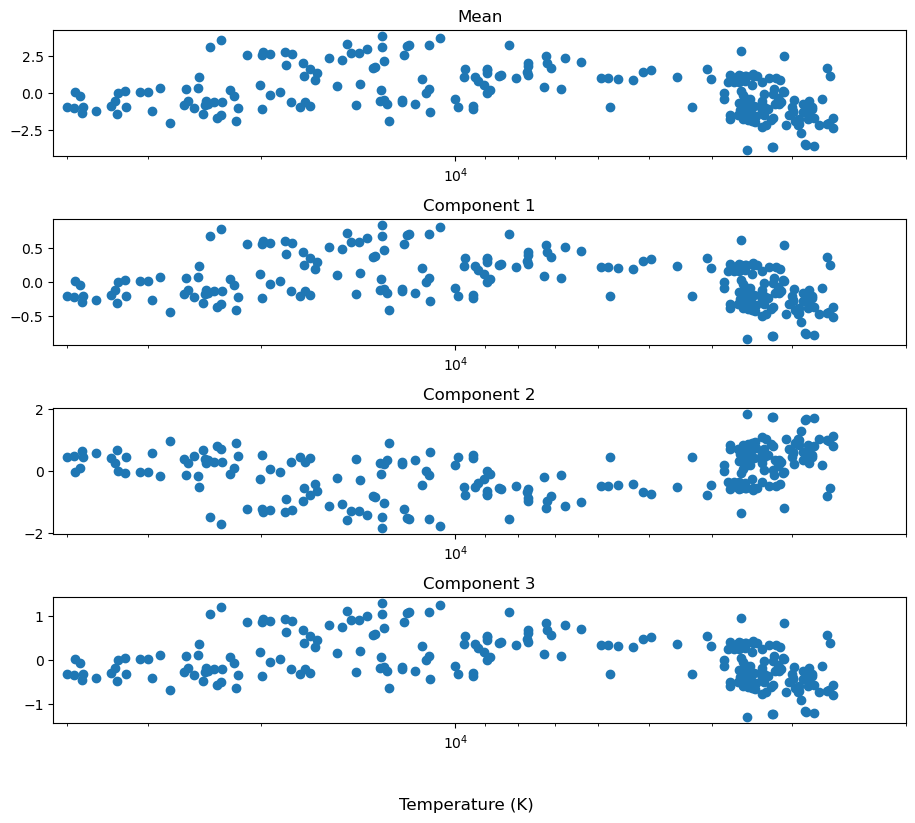

In [13]:
fig, axes = plt.subplots(n_components+1,1,figsize=(11,9))
fig.subplots_adjust(hspace=0.5)

for i in range(n_components+1):
    if i<1:
        axes[i].scatter(df_stars['Temperature (K)'],eigenvalues[:,1]*mean[1])
        axes[i].set_title('Mean')
    else:
        axes[i].scatter(df_stars['Temperature (K)'],eigenvalues[:,1]*eigenvectors[i-1,1])
        axes[i].set_title('Component '+str(i))

    axes[i].set_xscale('log')
    #axes[i].set_yscale('log')
    axes[i].set_xlim(4.2e4,2e3)
fig.supxlabel('Temperature (K)')
plt.show()

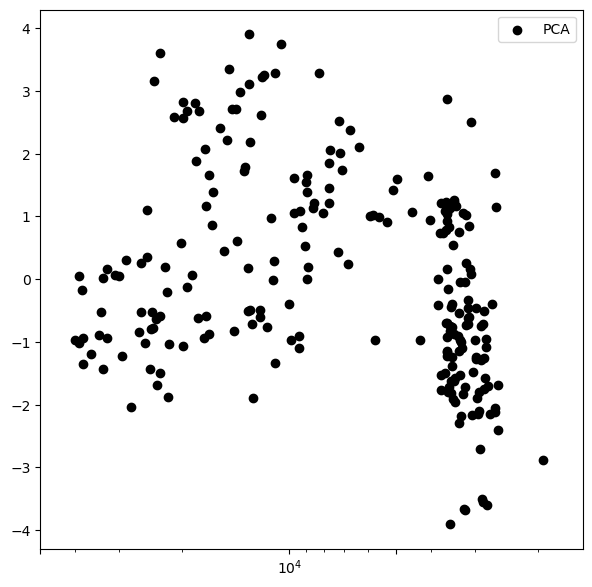

In [14]:
fig = plt.figure(figsize=(7, 7))
total = np.sum([eigenvalues[:,1]*eigenvectors[i,1] for i in range(n_components)])
total = total + eigenvalues[:,1]*mean[1]
plt.scatter(df_stars['Temperature (K)'],total,c='k',label='PCA')
#sns.scatterplot(data=df_stars, x='Temperature (K)', y='Luminosity(L/Lo)', hue=labels)
plt.xscale('log')
#plt.yscale('log')
plt.xticks([5000, 10000, 50000])
plt.xlim(5e4, 1.5e3)
plt.legend()
plt.show()

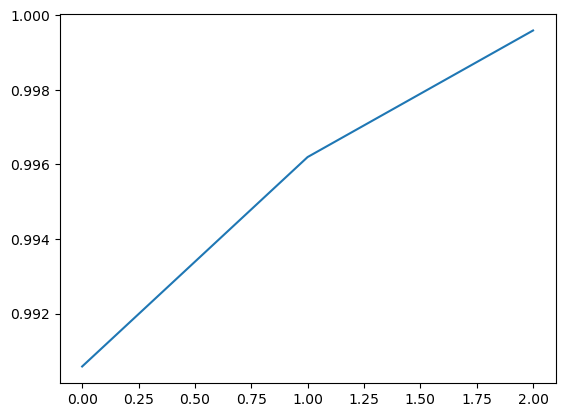

In [15]:
plt.plot(np.arange(n_components),pca.explained_variance_ratio_.cumsum())

In [26]:
X = np.vstack((total,np.array(df_stars['Temperature (K)']))).T
n_clusters = 6
clf = KMeans(n_clusters=n_clusters,n_init='auto') #Try 2 clusters to start with
clf.fit(X)
centers = clf.cluster_centers_ #location of the clusters
labels = clf.predict(total) #labels for each of the points

# plot the data color-coded by cluster id
colors = ['g','b','r','c','m','y']
for ii in range(n_clusters):
    plt.scatter(total[labels==ii],np.array(df_stars['Temperature (K)'])[ii], 
                c=colors[ii],alpha=0.5)
plt.xticks([5000, 10000, 50000])
plt.xlim(5e4, 1.5e3)


C:\Users\giuli\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


ValueError: Expected 2D array, got 1D array instead:
array=[-2.16820645e+00 -1.47226245e+00 -2.41001171e+00 -9.58245290e-01
 -2.87696997e+00 -1.75519336e+00 -2.05847070e+00 -1.68640011e+00
 -2.11665138e+00 -4.02604652e-01  9.25137149e-01 -5.98092885e-01
  8.55309620e-01  7.79420060e-01  1.69258319e+00 -5.35421006e-01
 -1.07451752e+00  7.41355932e-01 -7.35193226e-01 -8.72687499e-01
  1.10090264e+00  1.45427470e+00  2.01534593e+00  1.21700375e+00
  8.68219443e-01  3.90470038e+00  1.13217680e+00  2.06690291e+00
  3.24984762e+00  2.51586061e+00 -1.02145933e+00  5.78117247e-02
  4.46289928e-01  1.05739254e+00  1.02147689e+00  1.05175154e+00
  2.37035688e+00  2.10657841e+00  1.01190354e+00  9.83592984e-01
  1.15522744e-02 -9.06853587e-01 -1.09340558e+00  2.52460240e-01
 -9.67592166e-01 -6.91220206e-01 -1.61269612e-01 -1.79516401e+00
 -7.04743303e-01 -5.21561893e-01 -3.89270968e-01 -1.52570669e+00
 -4.12301365e-01 -1.77166622e+00 -1.49850175e+00  1.26278170e+00
  1.09043945e+00  1.22453642e+00  1.21803921e+00  1.13058067e+00
 -2.29607853e+00 -1.96131131e+00 -4.60623307e-01 -1.26017169e+00
 -2.10517664e+00 -2.17549238e+00 -2.15529736e+00 -1.57412752e+00
 -1.69543317e+00 -3.50843435e+00 -1.13767907e+00  1.70859439e-01
 -1.00390544e+00 -4.64026756e-01  8.27607019e-01  1.01580814e+00
 -7.43834818e-01  7.49500457e-01  1.15003141e+00 -3.38781995e-01
  1.73761809e+00  3.74284518e+00  1.65904756e+00  2.07862124e+00
  2.70769427e+00  1.60999308e+00  2.60940662e+00  3.29139348e+00
  2.98445452e+00  2.82797810e+00  9.08509277e-01  1.07097393e+00
  1.65090918e+00  1.60245676e+00  5.30321909e-01  9.78958504e-01
  1.42678556e+00  1.21863076e+00 -5.96729039e-01 -1.19665285e+00
  2.28426332e-02 -9.68162584e-01 -5.85838238e-01 -5.93942042e-01
 -1.08692033e-02 -8.30614495e-01 -1.42612210e+00 -4.84440321e-01
 -5.22057148e-01 -1.42929272e+00  1.17745158e+00  1.17010217e+00
  1.07289969e+00  1.16542178e+00  1.04551630e+00  1.15950579e+00
  9.36783880e-01  1.23138470e+00  2.49094110e-01  7.42358418e-01
 -1.52283826e+00 -3.90317633e+00 -3.67832280e+00 -7.18341772e-01
 -1.81462119e+00 -3.66892051e+00 -1.79557090e+00 -7.18393028e-01
 -3.55034834e+00 -2.15332057e+00  2.50483347e+00  2.86903803e+00
  1.65285557e-01 -1.24613439e+00 -8.18503021e-01 -1.83371885e+00
  9.10591111e-02 -9.18952285e-01 -4.83423179e-02 -7.37852455e-01
  1.72823442e+00  2.58557413e+00  1.88805776e+00  2.71564512e+00
  3.21982005e+00  1.38921321e+00  2.19159445e+00  3.35303317e+00
  1.84819454e+00  3.11547083e+00 -1.22260090e+00  1.55629941e+00
  6.06178515e-01  1.39217915e+00  3.46921811e-01  3.10031402e-01
  2.61020228e-01  5.75857812e-01  1.75980363e-01 -9.29925792e-01
 -1.01546350e+00 -7.53351236e-01 -1.88968291e+00 -9.72386351e-01
  1.97161350e-03  4.36758796e-01 -1.06162634e+00 -8.36101524e-01
 -9.33594875e-01 -1.10160387e+00 -1.70983671e+00 -7.64303908e-01
 -9.70410140e-01 -5.29085922e-01 -1.22710901e+00 -1.14734417e+00
 -6.18207456e-01  2.85941628e-01 -4.84307746e-01 -7.98110993e-01
 -5.11532441e-01 -2.70826849e+00 -1.57679180e+00 -1.71244779e+00
 -1.62376944e+00 -1.28451057e+00 -1.88703535e+00 -1.38061686e+00
 -3.59867351e+00 -1.61770693e+00  5.46700310e-01  1.05018297e+00
 -1.26764165e+00 -4.76700618e-02 -4.38954610e-01 -1.15581385e+00
 -6.21092296e-01 -1.24242810e+00 -9.63137009e-01 -1.91125358e+00
  1.66185827e+00  2.40737145e+00  2.21813152e+00  1.79257034e+00
  2.80116054e+00  2.57578784e+00  3.16363589e+00  3.61080444e+00
  2.68639246e+00  2.67280495e+00  1.90624721e-01 -3.95990469e-01
 -5.11080746e-01 -2.02845223e-01 -8.88406851e-01 -9.43033920e-01
  1.08875793e+00 -1.17265838e-01  1.17062527e+00  3.28061765e+00
 -6.35011659e-01 -7.15094896e-01 -9.00936198e-01 -1.68551100e+00
 -8.66191363e-01  7.28443954e-02 -9.61395849e-01 -1.32840257e+00
 -1.48824342e+00 -1.02940792e+00 -7.82201661e-01 -1.78911596e-01
  1.55467243e-01 -2.03341548e+00 -1.88060783e+00  5.65862645e-02
  6.04688632e-02  2.00648582e-01  8.24664413e-01 -1.35080248e+00].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.